# Counting Easter eggs
Our experiment compares the classification approach and the regression approach. The selection is done with the `class_mode` option in Keras' ImageDataGenerator flow_from_directory. `categorical` is used for the one-hot encoding and `sparse` for integers as classes.

Careful: While this is convention there, in other contexts, 'sparse' might mean a vector representation with more-than-one-hot entries, and rather the term 'binary' would be used for integers, generalizing a binary 0/1 problem to several possible classes.

In the notebook, the class_mode is used as a switch for the different Net variants and evaluation scripting.

In [1]:
class_mode = "sparse"

## Imports and version numbers

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
import os
import re
import numpy as np
from tensorflow.keras.preprocessing.image import load_img

In [3]:
# Python version: 3.8
print(tf.__version__)

2.3.1


In [4]:
# CUDA version:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:12:52_Pacific_Daylight_Time_2019
Cuda compilation tools, release 10.1, V10.1.243


## Prepare data for the training
If you redo this notebook on your own, you'll need the images with 0..7 (without 5) eggs in the folders `./images/0` ... `./images/7` (`./images/5` must exist for the classification training, but be empty)

In [7]:
data_directory = "C:\\Users\\Tobias\\Documents\\easter-egg-AI\\images"

input_shape = [64,64,3] # 256
batch_size = 16

seed = 123 # for val split

train_datagen = ImageDataGenerator(
    validation_split=0.2,
    rescale=1.0/255.0
    )

train_generator = train_datagen.flow_from_directory(
    data_directory,
    seed=seed,
    target_size=(input_shape[0],input_shape[1]),
    color_mode="rgb",
    class_mode=class_mode,
    batch_size=batch_size,
    subset='training'
)

val_datagen = ImageDataGenerator(
    validation_split=0.2,
    rescale=1.0/255.0
    )
    
val_generator = val_datagen.flow_from_directory(
    data_directory,
    seed=seed,
    target_size=(input_shape[0],input_shape[1]),
    color_mode="rgb",
    class_mode=class_mode,
    batch_size=batch_size,
    subset='validation'
)


Found 11200 images belonging to 8 classes.
Found 2800 images belonging to 8 classes.


## Prepare the model

In [8]:

num_classes = 8 # because 0..7 eggs
if class_mode == "categorical":
    num_output_dimensions = num_classes
if class_mode == "sparse":
    num_output_dimensions = 1

model = tf.keras.Sequential()

model.add( tf.keras.layers.Conv2D(
    filters = 4,
    kernel_size = 5,
    strides = 1,
    padding = 'same',
    activation = 'relu',
    input_shape = input_shape
    ))
model.add( tf.keras.layers.MaxPooling2D(
    pool_size = 2, strides = 2
    ))
model.add( tf.keras.layers.Conv2D(
    filters = 8,
    kernel_size = 5,
    strides = 1,
    padding = 'same',
    activation = 'relu'
    ))
model.add( tf.keras.layers.MaxPooling2D(
    pool_size = 2, strides = 2
    ))
model.add( tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(
    units = 16, activation = 'relu'
    ))
if class_mode == "categorical":
    last_activation = 'softmax'
if class_mode == "sparse":
    last_activation = None
model.add(tf.keras.layers.Dense(
    units = num_output_dimensions, activation = last_activation
    ))

if class_mode == "categorical":
    loss = 'categorical_crossentropy'
if class_mode == "sparse":
    loss = 'mse'
model.compile(
    optimizer = 'adam',
    loss = loss,
    metrics = ['accuracy']
    )

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 4)         304       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 8)         808       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 8)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 16)                32784     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

## Train the model
(on 0,1,2,3,4,6,7, but not 5 eggs)

In [9]:
epochs = 5

model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    )


Epoch 1/5
700/700 [==============================] - 34s 48ms/step - loss: 0.6279 - accuracy: 0.2662 - val_loss: 0.0420 - val_accuracy: 0.2857
Epoch 2/5
700/700 [==============================] - 26s 38ms/step - loss: 0.0281 - accuracy: 0.2857 - val_loss: 0.0148 - val_accuracy: 0.2857
Epoch 3/5
700/700 [==============================] - 27s 38ms/step - loss: 0.0235 - accuracy: 0.2857 - val_loss: 0.0172 - val_accuracy: 0.2857
Epoch 4/5
700/700 [==============================] - 27s 38ms/step - loss: 0.0242 - accuracy: 0.2857 - val_loss: 0.0129 - val_accuracy: 0.2857
Epoch 5/5
700/700 [==============================] - 27s 38ms/step - loss: 0.0252 - accuracy: 0.2857 - val_loss: 0.0202 - val_accuracy: 0.2857


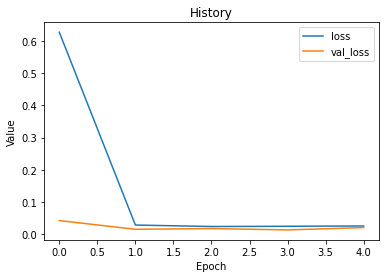

In [10]:
plt.figure()

if class_mode == "categorical":
    plt.plot(model.history.history['accuracy'])
    plt.plot(model.history.history['val_accuracy'])
    plt.title('History')
    plt.ylabel('Value')
    plt.xlabel('Epoch')
    plt.legend(['accuracy','val_accuracy'], loc='best')
    plt.show()

if class_mode == "sparse":
    plt.plot(model.history.history['loss'])
    plt.plot(model.history.history['val_loss'])
    plt.title('History')
    plt.ylabel('Value')
    plt.xlabel('Epoch')
    plt.legend(['loss','val_loss'], loc='best')
    plt.show()

Save the model

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: regression_model\assets
